In [1]:
# data processing packages
import numpy as np
import pandas as pd
from pandas import DataFrame

# model packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.externals import joblib
from keras.models import load_model
import glob

# evaluation packages
from sklearn.metrics import roc_curve
from sklearn.model_selection import learning_curve

# plot packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# obtain valid data
signal_test = pd.read_hdf('./data/signal_test.hdf','signal')

feature_name = signal_test.columns.tolist()
feature_name.remove('eid')
feature_name.remove('truth_matching')
feature_name.remove('upsmcmass')
feature_name.remove('A1mcmass')
feature_name.remove('A2mcmass')
feature_name.remove('A3mcmass')

X_test = signal_test[feature_name]
y_test = signal_test['truth_matching']
print X_test.shape, y_test.shape

weight_test = np.zeros(y_test.shape)
weight_test = weight_test + 1
weight_test[y_test==1] = y_test.shape[0] / sum(y_test)

Using Theano backend.


(880105, 17) (880105,)


/Users/yunxuanli/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:40: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


Plotting ROC curve...
./models/dt.pkl
./models/gbdt100.pkl
./models/lg.pkl
./models/rf10.pkl


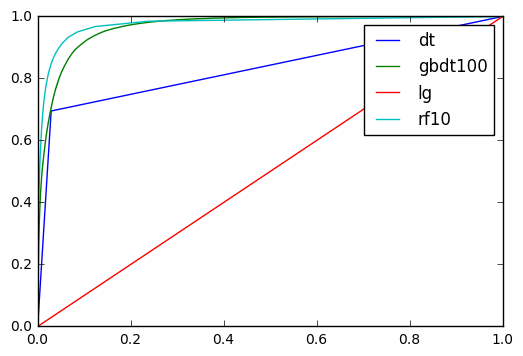

In [2]:
# ROC curve:
print 'Plotting ROC curve...'
model_list_sklearn = glob.glob('./models/*.pkl')
model_list_keras = glob.glob('./models/*.h5')
model_list = model_list_sklearn + model_list_keras

for model in model_list:
    print model
    if(model in model_list_sklearn):
        rf = joblib.load(model)
        y_pred_prob = rf.predict_proba(X_test)[:,1]
        fpr,tpr,thresholds = roc_curve(y_test, y_pred_prob, sample_weight=weight_test)
        plt.plot(fpr,tpr,label=model[9:-4])
    elif(model in model_list_keras):
        rf = load_model(model)
        y_pred_prob = rf.predict(X_test.values)
        fpr,tpr,thresholds = roc_curve(y_test.values, y_pred_prob, sample_weight=weight_test)
        plt.plot(fpr,tpr,label=model[9:-3])
    else:
        print 'Error'

plt.legend()

In [4]:
# calculate cr_score for test set using gbdt100
rf = joblib.load('./models/gbdt100.pkl')
signal_test['cr_score'] = pd.Series(rf.predict_proba(signal_test[feature_name])[:,1], index=signal_test.index)

# use highest cr_score to construct event table
"""
event_list = []
for eid, candidates in signal_test.groupby('eid'):
    event_list.append(candidates.ix[candidates['cr_score'].argmax()])
events_test = DataFrame(event_list, columns=signal_test.columns)
events_test.to_hdf('./data/events_test.hdf','event')
"""
events_test = pd.read_hdf('./data/events_test.hdf','event')

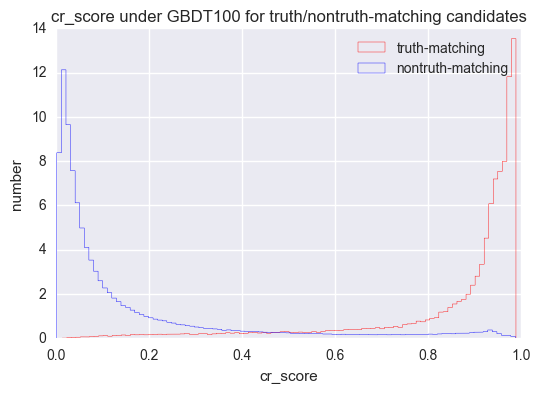

In [74]:
#plt.hist((events_test.upsmcmass - events_test.upsmass),bins=100,range=[0,1])
#plt.hist((events_test.A1mcmass - events_test.A1mass),bins=100,range=[0,0.5])
plt.hist(signal_test[signal_test.truth_matching==True].cr_score, bins=100, color='r',label='truth-matching',histtype='step', normed=True)
plt.hist(signal_test[signal_test.truth_matching==False].cr_score, bins=100, color='b',label='nontruth-matching',histtype='step', normed=True)
plt.legend()
plt.xlabel('cr_score')
plt.ylabel('number')
plt.title('cr_score under GBDT100 for truth/nontruth-matching candidates')

0.13829
0.00843293

0.36101


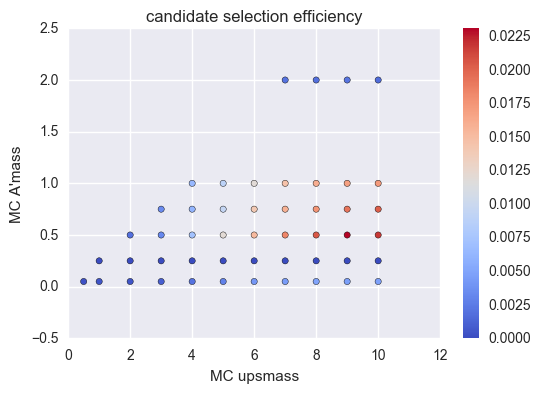

In [109]:
# efficiency for gbdt100 under different (upsmcmass, Amcmass) pairs

# hyperparameters: box size and threshold
delta = 0.2
percentile = 70
delta_ups = np.percentile((events_test.upsmcmass - events_test.upsmass), percentile)
delta_A = np.percentile((events_test.A1mcmass - events_test.A1mass), percentile)
threshold = 0.8
print delta_ups
print delta_A
print

# MC hypothesises
upsmcmass_list = [0.5, 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]
Amcmass_list = [0.05, 0.25, 0.5, 0.75, 1.0, 2.0]
mcmass_list = [[upsmcmass, Amcmass] for upsmcmass in upsmcmass_list for Amcmass in Amcmass_list if upsmcmass>3*Amcmass]
N_count_list = []

for upsmcmass_, Amcmass_ in mcmass_list:
    # events under a certain (upsmass, Amcmass) hypothesis pair
    filte = (events_test.upsmcmass<upsmcmass_+delta_ups) & (events_test.upsmcmass>upsmcmass_-delta_ups) \
        & (events_test.A1mcmass<Amcmass_+delta_A) & (events_test.A1mcmass>Amcmass_-delta_A) \
        & (events_test.upsmass<upsmcmass_+delta_ups) & (events_test.upsmass>upsmcmass_-delta_ups) \
        & (events_test.A1mass<Amcmass_+delta_A) & (events_test.A1mass>Amcmass_-delta_A)
    events_singleMChypothesis = events_test[filte]
    
    # number of signals
    N_count = events_singleMChypothesis[events_singleMChypothesis.cr_score > threshold].shape[0]
    N_count_list.append(N_count*1.0/events_test.shape[0])

print sum(N_count_list)
# plot
from matplotlib import cm
mcmass_np = np.array(mcmass_list)
plt.scatter(mcmass_np[:,0], mcmass_np[:,1], c=N_count_list, cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel('MC upsmass')
plt.ylabel('MC A\'mass')
plt.title('candidate selection efficiency')

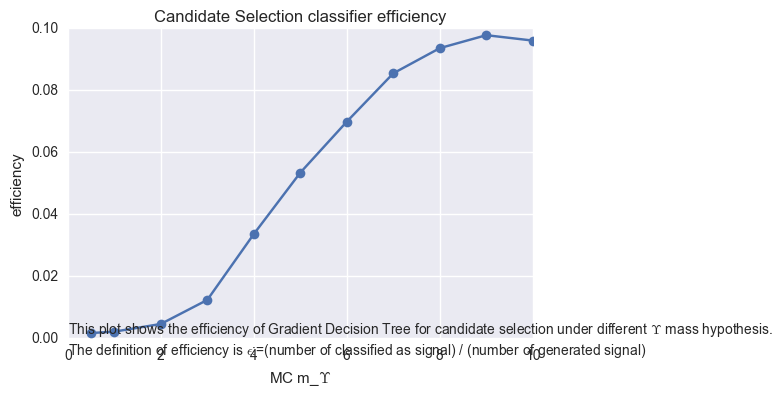

In [110]:
# MC hypothesises
upsmcmass_list = [0.5, 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]
#Amcmass_list = [0.05, 0.25, 0.5, 0.75, 1.0, 2.0]
#mcmass_list = [[upsmcmass, Amcmass] for upsmcmass in upsmcmass_list for Amcmass in Amcmass_list if upsmcmass>3*Amcmass]
N_count_list = []

for upsmcmass_ in upsmcmass_list:
    # events under a certain (upsmass, Amcmass) hypothesis pair
    filte = (events_test.upsmcmass<upsmcmass_+delta_ups) & (events_test.upsmcmass>upsmcmass_-delta_ups) \
        & (events_test.upsmass<upsmcmass_+delta_ups) & (events_test.upsmass>upsmcmass_-delta_ups)
    events_singleMChypothesis = events_test[filte]
    
    # number of signals
    N_count = events_singleMChypothesis[events_singleMChypothesis.cr_score > threshold].shape[0]
    N_count_list.append(N_count*1.0/events_test.shape[0])

plt.plot(upsmcmass_list, N_count_list,'-o')
plt.xlabel('MC m_$\Upsilon$')
plt.ylabel('efficiency')
plt.title('Candidate Selection classifier efficiency')
txt = "This plot shows the efficiency of Gradient Decision Tree for candidate selection under different $\Upsilon$ mass hypothesis.\n\
The definition of efficiency is $\epsilon$:=(number of classified as signal) / (number of generated signal)"
plt.text(.0, -.005, txt)

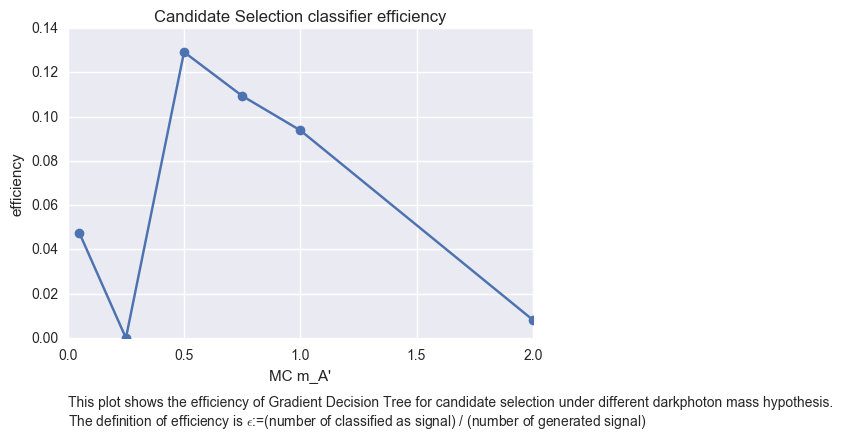

In [111]:
# MC hypothesises
#upsmcmass_list = [0.5, 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]
Amcmass_list = [0.05, 0.25, 0.5, 0.75, 1.0, 2.0]
#mcmass_list = [[upsmcmass, Amcmass] for upsmcmass in upsmcmass_list for Amcmass in Amcmass_list if upsmcmass>3*Amcmass]
N_count_list = []

for Amcmass_ in Amcmass_list:
    # events under a certain (upsmass, Amcmass) hypothesis pair
    filte = (events_test.A1mcmass<Amcmass_+delta_A) & (events_test.A1mcmass>Amcmass_-delta_A) \
        & (events_test.A1mass<Amcmass_+delta_A) & (events_test.A1mass>Amcmass_-delta_A)
    events_singleMChypothesis = events_test[filte]
    
    # number of signals
    N_count = events_singleMChypothesis[events_singleMChypothesis.cr_score > threshold].shape[0]
    N_count_list.append(N_count*1.0/events_test.shape[0])

plt.plot(Amcmass_list, N_count_list,'-o')
plt.xlabel('MC m_A\'')
plt.ylabel('efficiency')
plt.title('Candidate Selection classifier efficiency')
txt = "This plot shows the efficiency of Gradient Decision Tree for candidate selection under different darkphoton mass hypothesis.\n\
The definition of efficiency is $\epsilon$:=(number of classified as signal) / (number of generated signal)"
plt.text(0, -0.04, txt)

10.0 2.0
(180, 24)


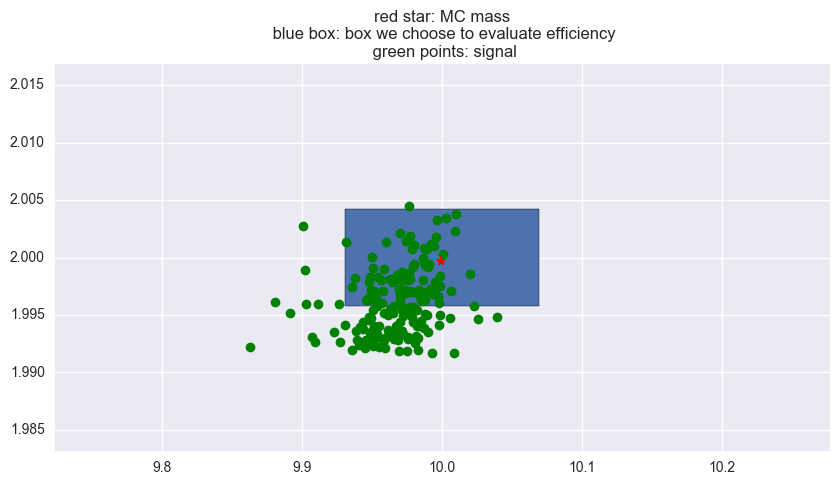

In [116]:
upsmcmass_,Amcmass_ = 10.0, 2.0
print upsmcmass_,Amcmass_
filte = (events_test.upsmcmass<upsmcmass_+delta_ups) & (events_test.upsmcmass>upsmcmass_-delta_ups) \
        & (events_test.A1mcmass<Amcmass_+delta_A) & (events_test.A1mcmass>Amcmass_-delta_A) \
        & (events_test.upsmass<upsmcmass_+delta_ups) & (events_test.upsmass>upsmcmass_-delta_ups) \
        & (events_test.A1mass<Amcmass_+delta_A) & (events_test.A1mass>Amcmass_-delta_A)
        
events_singleMC = events_test[filte]
events_signal = events_singleMC[events_singleMC.cr_score > threshold]
print events_signal.shape

import matplotlib.patches as patches
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)
ax1.add_patch(
            patches.Rectangle(
                (upsmcmass_-delta_ups/2.0, Amcmass_-delta_A/2.0),
                delta_ups,
                delta_A,))
#plt.plot(events_singleMC.upsmass, events_singleMC.A1mass,'o', color='b')
ax1.plot(events_signal.upsmass, events_signal.A1mass,'o', color='g')
ax1.plot(events_singleMC.upsmcmass, events_singleMC.A1mcmass,'*', color='r')
plt.xlim(upsmcmass_-2*delta_ups, upsmcmass_+2*delta_ups)
plt.ylim(Amcmass_-2*delta_A, Amcmass_+2*delta_A)
txt = 'red star: MC mass\n blue box: box we choose to evaluate efficiency\n green points: signal'
plt.title(txt)